In [1]:
import h5py
import numpy as np
import puma
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot, Roc, RocPlot
from puma.metrics import calc_rej
from puma.utils import get_good_colours, get_good_linestyles, logger
from sklearn import metrics
from numpy.lib.recfunctions import structured_to_unstructured as s2u

In [2]:
plt.rcParams.update({
    "figure.facecolor":  "w", 
    "axes.facecolor":    "w", 
    "savefig.facecolor": "w", 
})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sig_eff_min = 0.2 #0.4
sig_eff = np.linspace(sig_eff_min, 1.0, 100)
# if sig_eff_min < 0.2 and key != 'RNN':
#     sig_eff = np.linspace(0.2, 1, 20)

In [5]:
sig_eff

array([0.2       , 0.20808081, 0.21616162, 0.22424242, 0.23232323,
       0.24040404, 0.24848485, 0.25656566, 0.26464646, 0.27272727,
       0.28080808, 0.28888889, 0.2969697 , 0.30505051, 0.31313131,
       0.32121212, 0.32929293, 0.33737374, 0.34545455, 0.35353535,
       0.36161616, 0.36969697, 0.37777778, 0.38585859, 0.39393939,
       0.4020202 , 0.41010101, 0.41818182, 0.42626263, 0.43434343,
       0.44242424, 0.45050505, 0.45858586, 0.46666667, 0.47474747,
       0.48282828, 0.49090909, 0.4989899 , 0.50707071, 0.51515152,
       0.52323232, 0.53131313, 0.53939394, 0.54747475, 0.55555556,
       0.56363636, 0.57171717, 0.57979798, 0.58787879, 0.5959596 ,
       0.6040404 , 0.61212121, 0.62020202, 0.62828283, 0.63636364,
       0.64444444, 0.65252525, 0.66060606, 0.66868687, 0.67676768,
       0.68484848, 0.69292929, 0.7010101 , 0.70909091, 0.71717172,
       0.72525253, 0.73333333, 0.74141414, 0.74949495, 0.75757576,
       0.76565657, 0.77373737, 0.78181818, 0.78989899, 0.79797

In [12]:
networks = {
    # "GN1Tau" : "logs/GN1_tau_20230215-T172736/ckpts/epoch=021-val_loss=0.31938__test_ttbar.h5"
    # 'GN1Tau': "logs/GN1_tau_20230321-T145044/ckpts/epoch=018-val_loss=0.08698__test_inclusive_testing_ttbar_PFlow.h5"
    # 'GN1Tau' : "logs/GN1_tau_20230325-T210222/ckpts/epoch=023-val_loss=0.07746__test_inclusive_testing_ttbar_PFlow.h5"
    #  'GN2TauA': 'logs/GN2TauA_20230820-T185727/ckpts/epoch=009-val_loss=0.04711__test_pp_output_test.h5' ,
    #  "GN2TauJ" : "logs/GN2TauJ_20230713-T111312/ckpts/epoch=010-val_loss=0.05086__test_pp_output_test.h5" ,
    #  "GN2TauC" : "logs/GN2TauC_20230713-T151458/ckpts/epoch=011-val_loss=0.05114__test_pp_output_test.h5" ,
    #  "GN2Tau" : "logs/GN2Tau_20230726-T175600/ckpts/epoch=008-val_loss=0.05920__test_pp_output_test.h5"
    #"GN2Tau" : "logs/GN2Tau_20230508-T191218/ckpts/epoch=021-val_loss=0.07711__test_PFlow.h5"
    # "GN1Tau" : "/storage/agrp/zivka/salt/run/logs/GN1_tau_20230226-T104411/ckpts/epoch=028-val_loss=0.28814__test_inclusive_testing_ttbar_PFlow.h5",
    # "GN1Tau + Aux" : "logs/GN1_tau_20230218-T231137/ckpts/epoch=028-val_loss=0.28814__test_ttbar.h5"
    #"GN2TauA": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=012-val_loss=0.05973__test_pp_output_test.h5"
    #"GNTau_noAux": "/storage/agrp/dreyet/GNtau/salt/logs/GN2Tau_noAux_20230920-T112330/ckpts/epoch=028-val_loss=0.06778__test_pp_output_test.h5",
    #"GNTauA": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=017-val_loss=0.05848__test_pp_output_test.h5",
    "GN2TauA_trkClsWgt_noRNN": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_pp_output_test.h5",
    "GN2TauA_trkClsWgt_noRNN_noAux": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_noAux_20230927-T200138/ckpts/epoch=037-val_loss=0.06664__test_pp_output_test.h5",
    #"GN2TauA_trkClsWgt": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_20230924-T171327/ckpts/epoch=019-val_loss=0.05785__test_pp_output_test.h5",
    #"GN2Tau_noAux": "/storage/agrp/dreyet/GNtau/salt/logs/GN2Tau_noAux_20230922-T110104/ckpts/epoch=042-val_loss=0.06758__test_pp_output_test.h5",
}

In [7]:
reference = "RNN"
# reference  = 'GN2Tau'

#test_path =  '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output/pp_output_test.h5'
test_path =  '/storage/agrp/dreyet/GNtau/samples/v04/output/pp_output_test.h5'

#test_path = '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output_1/pp_output_test.h5'
#'/storage/agrp/dmitrykl/tauTag/upp/output/pp_output_test.h5'

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    # you can adapt this for your needs
    return np.log((arr[0] + 1e-10) / (arr[1] + 1e-10))

with h5py.File(test_path, 'r') as test_f:
    print(test_f['tracks'][0].dtype)
    jet_pt = test_f['jets']['pt'] / 1000
    jet_eta = test_f['jets']['absEta']
    jet_flav = test_f['jets']['HadronConeExclTruthLabelID']
    rnn_pTau = test_f['jets']['TAU_RNNJetScoreSigTrans'] #using Trans Score!!!
    rnn_pBkg = 1 - test_f['jets']['TAU_RNNJetScoreSigTrans']
    track_scores = [test_f['tracks']['rnn_fakeScore'], test_f['tracks']['rnn_chargedScore'], test_f['tracks']['rnn_isolationScore'], test_f['tracks']['rnn_conversionScore']]
    #print(track_scores, '*')
    track_valids = test_f['tracks']['valid']
    #print(track_valids)
    track_truth = test_f['tracks']['NewTruthType']
    n_tracks = np.sum(track_valids, axis=-1)
    #print(n_tracks)
    prongs = np.sum(np.argmax(np.stack(track_scores,axis=-1), axis=-1)==1, axis=-1)
    #print(prongs, '^')
    # prongs = np.sum(track_truth == 1, axis=-1)
    eta_mask = (jet_eta < 2.5) & ((jet_eta > 1.57) | (jet_eta < 1.37))
    mask = (rnn_pTau >= 0) & (rnn_pBkg >= 0) & (jet_pt > 20) & eta_mask #& ((n_tracks == 1) | (n_tracks == 3))# & (jet_pt < 100)
    is_tau = jet_flav == 5
    is_bkg = jet_flav == 0
    n_jets_bkg = np.sum(is_bkg & mask)
    rnn_discs = rnn_pTau
    #rnn_discs = disc_fct(np.row_stack([rnn_pTau, rnn_pBkg]))

    x = test_f['tracks']['tauTruthProng']
    sig_1_prong = np.isin(x, 1)
    sig_mask_1 = np.any(sig_1_prong, axis=1)
    sig_3_prong = np.isin(x, 3)
    sig_mask_3 = np.any(sig_3_prong, axis=1)

    # rnn_discs = rnn_pTau
    logger.info("Calculate rejection")
    rnn_rej = calc_rej(rnn_discs[is_tau & mask], rnn_discs[is_bkg & mask], sig_eff)
    rnn_rej_0 = calc_rej(rnn_discs[is_tau & mask], rnn_discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
    # rnn_rej_1 = calc_rej(rnn_discs[is_tau & mask & (prongs==1)], rnn_discs[is_bkg & mask], sig_eff) ##without TauTruthProng mask
    # rnn_rej_3 = calc_rej(rnn_discs[is_tau & mask & (prongs==3)], rnn_discs[is_bkg & mask], sig_eff) ##without TauTruthProng mask
    rnn_rej_1 = calc_rej(rnn_discs[is_tau & mask & (prongs==1)& sig_mask_1], rnn_discs[is_bkg & mask & (prongs==1)], sig_eff)
    rnn_rej_3 = calc_rej(rnn_discs[is_tau & mask & (prongs==3)& sig_mask_3], rnn_discs[is_bkg & mask & (prongs==3)], sig_eff)

[('beamSpotWeight', '<f4'), ('TruthType', '<f4'), ('NewTruthType', '<f4'), ('truthJetType', '<f4'), ('z0sinthetaSigTJVA', '<f4'), ('z0sinthetaTJVA', '<f4'), ('d0SigTJVA', '<f4'), ('d0TJVA', '<f4'), ('z0TJVA', '<f4'), ('dz0_TV_PV0', '<f4'), ('log_sumpt_TV', '<f4'), ('log_sumpt2_TV', '<f4'), ('log_sumpt_PV0', '<f4'), ('log_sumpt2_PV0', '<f4'), ('isLRT', '<f4'), ('jetSeedPt', '<f4'), ('jetSeedEta', '<f4'), ('jetSeedPhi', '<f4'), ('tauPt', '<f4'), ('tauEta', '<f4'), ('tauPhi', '<f4'), ('dEtaJetSeedAxis', '<f4'), ('dPhiJetSeedAxis', '<f4'), ('dRJetSeedAxis', '<f4'), ('tauPtIntermediateAxis', '<f4'), ('dRIntermediateAxis', '<f4'), ('tauPtDetectorAxis', '<f4'), ('dRDetectorAxis', '<f4'), ('rConv', '<f4'), ('rConvII', '<f4'), ('charge', '<f4'), ('tauTruthCharge', '<f4'), ('tauTruthProng', '<f4'), ('tauTruthDecayMode', '<f4'), ('truthParticleOrigin', '<f4'), ('truthParticleType', '<f4'), ('trackPt', '<f4'), ('trackEta', '<f4'), ('trackPhi', '<f4'), ('truthE', '<f4'), ('numberOfInnermostPixelLay

INFO:puma: Calculate rejection


In [13]:
results = {}

In [14]:
results["RNN"] = {
        'sig_eff' : sig_eff,
        'disc' : rnn_discs,
        'rej' : rnn_rej,
        'rej_0' : rnn_rej_0,
        'rej_1' : rnn_rej_1,
        'rej_3' : rnn_rej_3,
        'pTau' : rnn_pTau,
        'pBkg' : rnn_pBkg,
        'prongs' : prongs,
    }

In [15]:
networks

{'GN2TauA_trkClsWgt_noRNN': '/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_pp_output_test.h5',
 'GN2TauA_trkClsWgt_noRNN_noAux': '/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_noAux_20230927-T200138/ckpts/epoch=037-val_loss=0.06664__test_pp_output_test.h5'}

In [16]:
logger.info("Calculate discriminants and rejection")
for key, val in networks.items():
    print(key, val)
    with h5py.File(val, 'r') as f:
        #if key == 'GN2TauJ':
            pt = f['jets']['pt'] / 1000
            # tracks_pred = f['tracks'].fields(['0', '1', '2', '3', '4', '5', '6'])[:]
            flav = f['jets']['HadronConeExclTruthLabelID']
            is_tau = flav == 5
            is_bkg = flav == 0
            print(f['jets'][0].dtype)
            if 'GN' in key:
                print(f['jets'])
                pTau = f['jets']['{}_pb'.format(key)]
                pBkg = f['jets']['{}_pu'.format(key)]
                discs = pTau
                #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            # if key == 'GN2Tau' or key == 'GNtau':
            #     pTau = f['jets']['GN2Tau_pb']
            #     pBkg = f['jets']['GN2Tau_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            # if key == 'GNTauA':
            #     pTau = f['jets']['GN2TauA_pb']
            #     pBkg = f['jets']['GN2TauA_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            #     #print(discs, key)
            # if key == 'GNTau_noAux' or key == 'GNtau_noAux':
            #     pTau = f['jets']['GN2Tau_noAux_pb']
            #     pBkg = f['jets']['GN2Tau_noAux_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg])) #with log!!
            #     #print(discs, key)
            # if key == 'GN2TauJ':
            #     pTau = f['jets']['GN2TauJ_pb']
            #     pBkg = f['jets']['GN2TauJ_pu']
            #     discs = pTau
            #     #discs = disc_fct(np.row_stack([pTau, pBkg]))
            #     #print(discs, key)
            # if key == 'GN2TauC':
            #     pTau = f['jets']['GN2TauC_pb']
            #     pBkg = f['jets']['GN2TauC_pu']
            #     discs = pTau
                #discs = disc_fct(np.row_stack([pTau, pBkg]))
                #print(discs, key)
            # # discs = pTau
            # mask = (pt > 20) & (pt < 100)
            # mask = (pt > 5)
            #eta_mask = (jet_eta < 2.5) & ((jet_eta > 1.57) | (jet_eta < 1.37))
            #mask = (pt > 20) & eta_mask #& ((n_tracks == 1) | (n_tracks == 3))# & (jet_pt < 100)
            #sig_eff = np.linspace(sig_eff_min, 1, 20)
            logger.info("Calculate rejection")
            rej = calc_rej(discs[is_tau & mask], discs[is_bkg & mask], sig_eff)
            rej_0 = calc_rej(discs[is_tau & mask], discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
            # rej_1 = calc_rej(discs[is_tau & mask & (prongs==1)], discs[is_bkg & mask], sig_eff)
            # rej_3 = calc_rej(discs[is_tau & mask & (prongs==3)], discs[is_bkg & mask], sig_eff)
            rej_1 = calc_rej(discs[is_tau & mask & (prongs==1) & sig_mask_1], discs[is_bkg & mask & (prongs==1)], sig_eff)
            rej_3 = calc_rej(discs[is_tau & mask & (prongs==3) & sig_mask_3], discs[is_bkg & mask & (prongs==3)], sig_eff)
            #print((mask & (jet_pt > 20) & is_bkg & (prongs == 3)).sum())
            results[key] = {
                    'sig_eff' : sig_eff,
                    'disc' : discs,
                    'rej' : rej,
                    'rej_0' : rej_0,
                    'rej_1' : rej_1,
                    'rej_3' : rej_3,
                    'pTau' : rnn_pTau,
                    'pBkg' : rnn_pBkg,
                }



INFO:puma: Calculate discriminants and rejection


GN2TauA_trkClsWgt_noRNN /storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_pp_output_test.h5
[('GN2TauA_trkClsWgt_noRNN_pu', '<f4'), ('GN2TauA_trkClsWgt_noRNN_pb', '<f4'), ('pt', '<f4'), ('absEta', '<f4'), ('HadronConeExclTruthLabelID', '<f4')]
<HDF5 dataset "jets": shape (17400000,), type "|V20">


INFO:puma: Calculate rejection


GN2TauA_trkClsWgt_noRNN_noAux /storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_noAux_20230927-T200138/ckpts/epoch=037-val_loss=0.06664__test_pp_output_test.h5
[('GN2TauA_trkClsWgt_noRNN_noAux_pu', '<f4'), ('GN2TauA_trkClsWgt_noRNN_noAux_pb', '<f4'), ('pt', '<f4'), ('absEta', '<f4'), ('HadronConeExclTruthLabelID', '<f4')]
<HDF5 dataset "jets": shape (17400000,), type "|V20">


INFO:puma: Calculate rejection


In [17]:
network_names = list(networks.keys())

for network in network_names:
    new_key = network.replace('GN2', 'GN')
    new_key = new_key.replace('Tau', 'tau')
    new_key = new_key.replace('auA', 'au')
    new_key = new_key.replace('_trkClsWgt', '')
    networks[new_key] = networks.pop(network)
    results[new_key] = results.pop(network)

In [ ]:
test_f = h5py.File(test_path, 'r')
print(test_f['jets'][0].dtype)
#jet_seed_pt = test_f['jets']['jetSeedPt']

[('TAU_centFrac', '<f4'), ('TAU_sumEMCellEtOverLeadTrkPt', '<f4'), ('TAU_dRmax', '<f4'), ('TAU_trFlightPathSig', '<f4'), ('TAU_etOverPtLeadTrk', '<f4'), ('TAU_ptRatioEflowApprox', '<f4'), ('TAU_mEflowApprox', '<f4'), ('TAU_massTrkSys', '<f4'), ('TAU_SumPtTrkFrac', '<f4'), ('TAU_EMPOverTrkSysP', '<f4'), ('TAU_isolFrac', '<f4'), ('TAU_RNNJetScore', '<f4'), ('TAU_RNNJetScoreSigTrans', '<f4'), ('HadronConeExclTruthLabelID', '<f4'), ('pt', '<f4'), ('absEta', '<f4'), ('eventNumber', '<f4'), ('flavour_label', '<i4')]


In [ ]:
x = test_f['tracks']['tauTruthProng']
x = x[is_tau]
x = x.flatten()
plt.hist(x)

In [ ]:
np.unique(track_truth)

In [4]:
track_scores = np.stack(track_scores,axis=-1)

In [5]:
prongs = np.argmax(np.stack(track_scores,axis=-1), axis=-1)


In [6]:
prongs

array([[  32691, 1514091, 2135369, 4318536],
       [    704,     704,     704,     704],
       [    112,     112,     112,     112],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [      0,       0,       0,       0],
       [  

In [ ]:
np.argmax(np.stack(track_scores,axis=-1), axis=-1)

In [ ]:
(mask & (jet_pt > 20) & is_bkg & (prongs == 1)).sum()

In [7]:
plt.hist(discs[mask & is_bkg & (prongs == 3)], density=True, histtype='step')
plt.hist(discs[mask & is_tau & (prongs == 3)], density=True, histtype='step')
plt.show()

NameError: name 'discs' is not defined

In [ ]:
np.sum(eta_mask)

In [ ]:
calc_rej(rnn_discs[is_tau & mask & (prongs==1)], rnn_discs[is_bkg & mask & (prongs==1)], np.array([0.6, 0.75, 0.85, 0.95]))

In [ ]:
rnn_discs[is_tau & mask & (prongs==3)]

In [ ]:
rnn_discs[is_bkg & mask & (prongs==3)]

In [ ]:
calc_rej(rnn_discs[is_tau & mask & (prongs==3)], rnn_discs[is_bkg & mask & (prongs==3)], np.array([0.45, 0.6, 0.75, 0.95]))

In [ ]:
np.sum(is_tau & mask & (prongs==3)) / (np.sum(is_tau & mask)) * 100

In [ ]:
discs[is_tau & mask & (prongs==1)]

In [ ]:
np.sum((prongs==1) & mask & is_tau)

In [ ]:
track_truth[track_valids]

In [ ]:
np.sum(np.argmax(np.stack(track_scores,axis=-1), axis=-1)==1, axis=-1)

In [ ]:
(mask & (jet_pt > 20) & is_bkg & (prongs == 3)).sum()

In [ ]:
f = h5py.File(val, 'r')

(array([ 945524.,   45404.,   26702.,   21869.,   21579.,   23419.,
          28163.,   37034.,   65458., 4584848.]),
 array([4.79183973e-06, 1.00004286e-01, 2.00003788e-01, 3.00003290e-01,
        4.00002778e-01, 5.00002265e-01, 6.00001752e-01, 7.00001299e-01,
        8.00000787e-01, 9.00000274e-01, 9.99999762e-01]),
 <BarContainer object of 10 artists>)

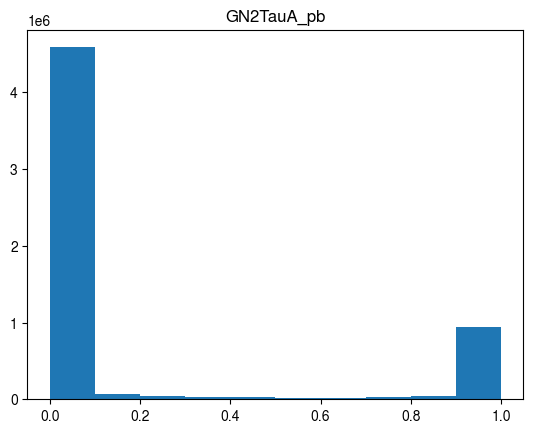

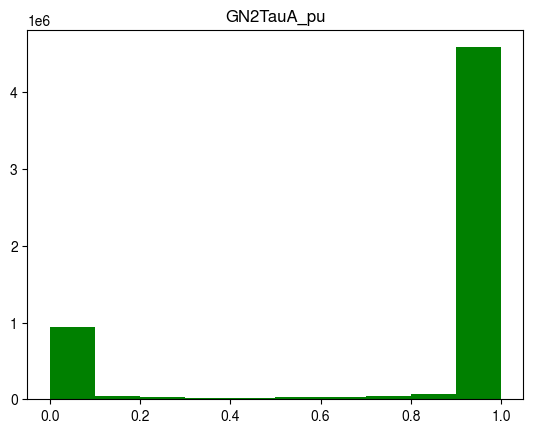

In [10]:
plt.figure()
plt.title('GN2TauA_pb')
plt.hist(f['jets']['GN2TauA_pb'])
plt.figure()
plt.title('GN2TauA_pu')
plt.hist(f['jets']['GN2TauA_pu'], color = 'g')



In [11]:
confusion_matrix = metrics.confusion_matrix(valid_truth, np.argmax(new_pred, axis=-1), normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

NameError: name 'valid_truth' is not defined

In [ ]:
rnn_scores = np.stack([track_scores[0], track_scores[1], track_scores[3], track_scores[2]], axis=-1)

In [ ]:
confusion_matrix = metrics.confusion_matrix(valid_truth, np.argmax(rnn_scores[track_valids], axis=-1), normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

KeyError: 'GN2Tau'

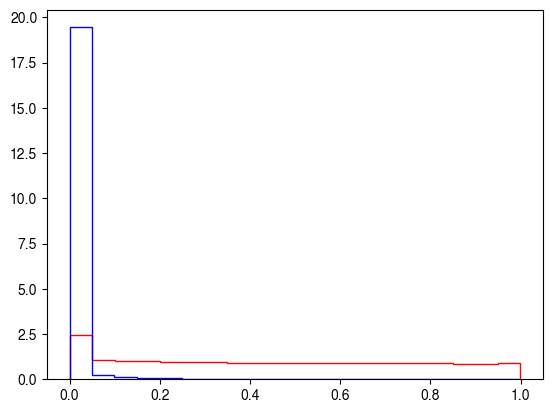

In [14]:
plt.hist(results['RNN']['disc'][is_tau & mask], histtype='step', density=True, bins=20, color='red', label='Tau')
plt.hist(results['RNN']['disc'][is_bkg & mask], histtype='step', density=True, bins=20, color='blue', label='Bkg')
plt.hist(results['GN2Tau']['disc'][is_tau & mask], histtype='step', density=True, bins=20, color='red', linestyle=('dashed'))
plt.hist(results['GN2Tau']['disc'][is_bkg & mask], histtype='step', density=True, bins=20, color='blue', linestyle=('dashed'))
plt.legend()
plt.show()

In [20]:
plt.hist(f['jets']['jetSeedPt'], bins=100, density=False, range=(0, 3500))
plt.yscale('log')
plt.show()

ValueError: Field jetSeedPt does not appear in this type.

In [19]:
indices = list(range(0, len(sig_eff), 2)) + [len(sig_eff) - 1]
#indices

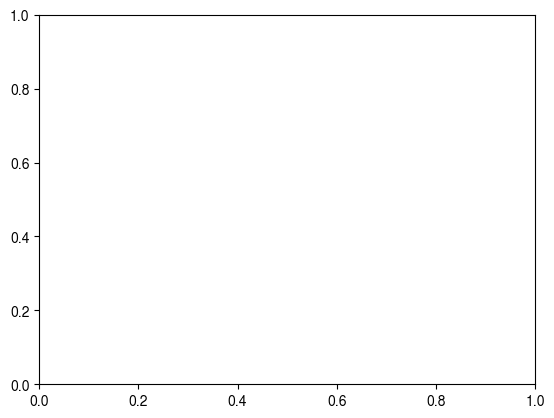

In [64]:
##plot only RNN for 1/3 prong

plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$" + f" TeV",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

plot_roc.add_roc(
    Roc(
        sig_eff[indices],
        results['RNN'][f'rej_1'][indices],
        n_test=np.sum(is_bkg & mask & (prongs==1)),
        rej_class="qcd",
        signal_class='$\\tau$-jets',
        label=f"{'RNN (1-prong)'}",
        colour='red',
    ),
    reference=True,
)

plot_roc.add_roc(
    Roc(
        sig_eff[indices],
        results['RNN'][f'rej_3'][indices],
        n_test=np.sum(is_bkg & mask & (prongs==3)),
        rej_class="qcd",
        signal_class='$\\tau$-jets',
        label=f"{'RNN (3-prong)'}",
        colour='steelblue',
        linestyle='dashed',
    ),
    reference=False,
)

# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd")
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"RNN_tau_both.png", transparent=False)

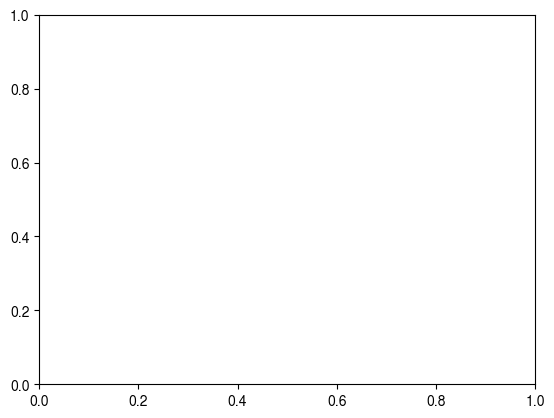

In [26]:

plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV\n1-prong\nTransScores",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

for network in results.keys():

    # if network not in ['RNN','GNtau_noRNN']:
    #     continue

    lab = network
    if '_' in lab:
        if 'noAux' in lab:
            lab = lab.split('_')[0] + '_noAux'
        else:
            lab = lab.split('_')[0]

    plot_roc.add_roc(
        Roc(
            sig_eff[indices],
            results[network]['rej_1'][indices],
            n_test=np.sum(is_bkg & mask & (prongs==1)),
            rej_class="qcd",
            signal_class='$\\tau$-jets',
            label=lab,
        ),
        reference=(reference == network),
    )
# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd")
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"All_tau_1.png", transparent=False)

In [ ]:
results['GN2TauJ']['rej_3'][0] = 5194.0
results['GN2TauJ']['rej_3'][1] = 5194.0

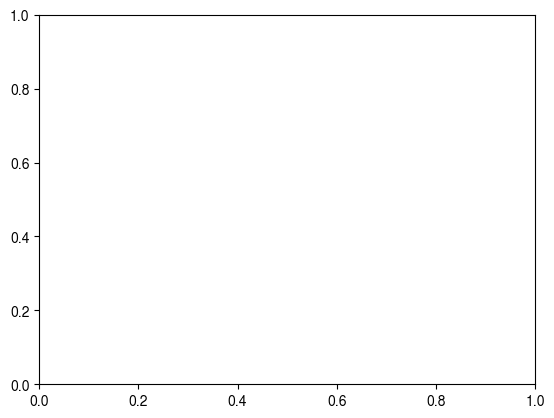

In [27]:
plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV\n3-prong\nTransScores",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

for network in results.keys():

    # if network not in ['RNN','GNtau_noRNN']:
    #     continue

    lab = network
    if '_' in lab:
        if 'noAux' in lab:
            lab = lab.split('_')[0] + '_noAux'
        else:
            lab = lab.split('_')[0]

    plot_roc.add_roc(
        Roc(
            sig_eff[indices],
            results[network]['rej_3'][indices],
            n_test=np.sum(is_bkg & mask & (prongs==3)),
            rej_class="qcd",
            signal_class='$\\tau$-jets',
            label=lab,
        ),
        reference=(reference == network),
    )
# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd")
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"All_tau_3.png", transparent=False)

# Efficiency/rejection vs. pT

In [22]:
import numpy as np

from puma import VarVsEff, VarVsEffPlot
from puma.utils import get_dummy_2_taggers, logger

In [23]:
WP_1p = {
    'Tight': 0.60,
    'Medium': 0.75,
    'Loose': 0.85,
}

WP_3p = {
    'Tight': 0.45,
    'Medium': 0.60,
    'Loose': 0.75,    
}

prongness = {'1 prongs':[(prongs==1) ,sig_mask_1, WP_1p, 1], '3 prongs' : [(prongs==3), sig_mask_3, WP_3p, 3]}

INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.


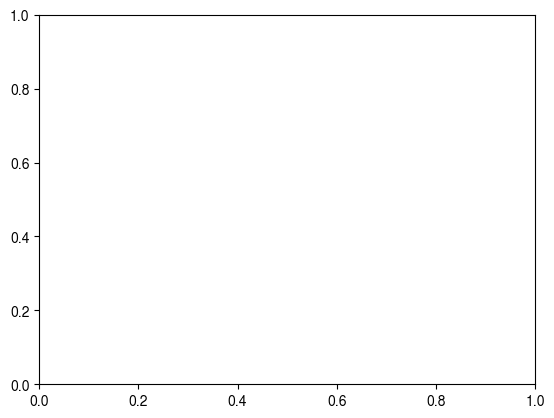

In [24]:
for WP_name in ['Tight', 'Medium', 'Loose']:

    for p_num, sigi, eff, prong in prongness.values():

        plot_sig_eff = VarVsEffPlot(
            mode="sig_eff",
            ylabel="$Tau$-jets efficiency",
            xlabel=r"$p_{T}$ [GeV]",
            logy=False,
            atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
            n_ratio_panels=1,
            ymin=0,
            ymax=1.6
        )

        plot_bkg_rej = VarVsEffPlot(
            mode="bkg_rej",
            ylabel="BKG-jets rejection",
            xlabel=r"$p_{T}$ [GeV]",
            logy=True,
            logx=True,
            atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
            n_ratio_panels=1,
            ymin=1,
            xmin=20,
            xmax=2100,
            #ymax= 970 if prong == 1 else 9700,
        )

        for network in results.keys(): 

            if network not in ['RNN','GNtau_noRNN']:
                continue

            lab = network
            if '_' in lab and 'Aux' not in lab:
                lab = lab.split('_')[0]

            vveff_eff = VarVsEff(
                x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
                disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
                x_var_bkg=jet_pt[is_bkg & mask & p_num],
                disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
                bins=np.linspace(20,1000,49),
                working_point=eff[WP_name],
                disc_cut=None,
                fixed_eff_bin=True,
                label=lab,
                )
            
            vveff_rej = VarVsEff(
                x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
                disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
                x_var_bkg=jet_pt[is_bkg & mask & p_num],
                disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
                bins=np.logspace(np.log10(20),np.log10(2000),8),
                working_point=eff[WP_name],
                disc_cut=None,
                fixed_eff_bin=True,
                label=lab,
                )            

            logger.info("Plotting bkg rejection for inclusive efficiency as a function of pt.")

            plot_sig_eff.add(vveff_eff, reference=(network == 'RNN'))
            plot_bkg_rej.add(vveff_rej, reference=(network == 'RNN'))

        plot_sig_eff.atlas_second_tag += "\n{} $(\\epsilon_{}\\tau{}={} \% )$".format(WP_name, '{','}' , eff[WP_name]*100)
        plot_bkg_rej.atlas_second_tag += "\n{} $(\\epsilon_{}\\tau{}={} \% )$".format(WP_name, '{','}' , eff[WP_name]*100)

        # If you want to inverse the discriminant cut you can enable it via
        # plot_sig_eff.set_inverse_cut()
        plot_sig_eff.draw()
        # Drawing a hline indicating inclusive efficiency
        plot_sig_eff.draw_hline(eff[WP_name])
        plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff_" + WP_name + ".png", transparent=False)

        plot_bkg_rej.draw()
        plot_bkg_rej.savefig('p_only'+str(prong)+"_bkg_rej_" + WP_name + ".png", transparent=False)

### RNN-only crosscheck

INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.
INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.


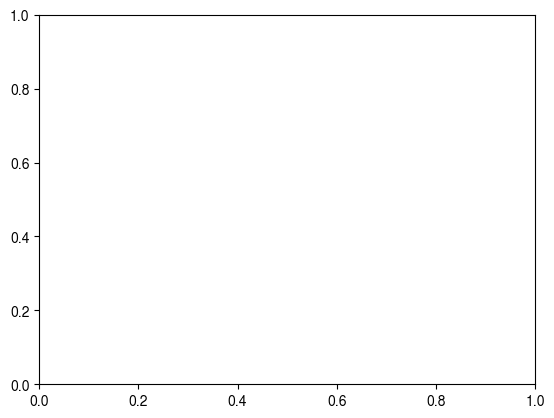

In [75]:
colors = {
    'Loose': 'green',
    'Medium': 'blue',
    'Tight': 'red',
}

for p_num, sigi, eff, prong in prongness.values():

    plot_sig_eff = VarVsEffPlot(
        mode="sig_eff",
        ylabel="$Tau$-jets efficiency",
        xlabel=r"$p_{T}$ [GeV]",
        logy=False,
        atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
        n_ratio_panels=0,
        ymin=0,
        ymax=1.6
    )

    plot_bkg_rej = VarVsEffPlot(
        mode="bkg_rej",
        ylabel="BKG-jets rejection",
        xlabel=r"$p_{T}$ [GeV]",
        logy=False,
        logx=True,
        atlas_second_tag="$\\sqrt{s}=13$ TeV, " + "{}-prong".format(prong) ,
        n_ratio_panels=0,
        ymin=0,
        ymax=1000. if prong == 1 else 10000.,
    )

    network = 'RNN'

    for WP_name in ['Tight', 'Medium', 'Loose']:

        vveff_eff = VarVsEff(
            x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
            disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
            x_var_bkg=jet_pt[is_bkg & mask & p_num],
            disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
            bins=np.linspace(20,1000,49),
            working_point=eff[WP_name],
            disc_cut=None,
            fixed_eff_bin=False,
            label='{} {} $(\\epsilon_{}\\tau{}={} \% )$'.format(network,WP_name, '{','}' , eff[WP_name]*100),
            colour=colors[WP_name],
            )
        
        vveff_rej = VarVsEff(
            x_var_sig=jet_pt[is_tau & mask & p_num & sigi],
            disc_sig=results[network]['disc'][is_tau & mask & p_num & sigi],
            x_var_bkg=jet_pt[is_bkg & mask & p_num],
            disc_bkg=results[network]['disc'][is_bkg & mask & p_num],
            bins=np.logspace(np.log10(20),np.log10(2000),11),
            working_point=eff[WP_name],
            disc_cut=None,
            fixed_eff_bin=False,
            label='{} {} $(\\epsilon_{}\\tau{}={} \% )$'.format(network,WP_name, '{','}' , eff[WP_name]*100),
            colour=colors[WP_name],
            )            

        logger.info("Plotting bkg rejection for inclusive efficiency as a function of pt.")

        plot_sig_eff.add(vveff_eff, reference=False)
        plot_bkg_rej.add(vveff_rej, reference=False)

        # Drawing a hline indicating inclusive efficiency
        plot_sig_eff.draw_hline(eff[WP_name])

    # If you want to inverse the discriminant cut you can enable it via
    # plot_sig_eff.set_inverse_cut()
    plot_sig_eff.draw()
    plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff_RNNcrosscheck.png", transparent=False)

    plot_bkg_rej.draw()
    plot_bkg_rej.savefig('p_only'+str(prong)+"_bkg_rej_RNNcrosscheck.png", transparent=False)

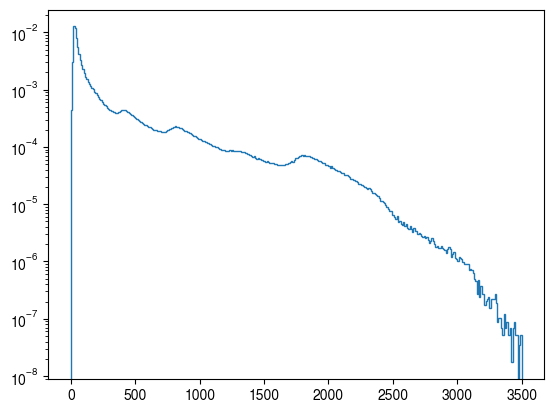

In [77]:
plt.hist(jet_pt, bins=350, density=True, range=(0, 3500), histtype='step')
plt.yscale('log')

In [ ]:
plt.hist(jet_pt[is_bkg & rnn_mask & (prongs==3)], bins = 30, log = True)

In [ ]:
plt.hist(results['GN2Tau']['disc'][is_tau & mask & (prongs==3)], bins = 30, log = True)